In [1]:
import os
import cv2
import random
import shutil
import time
import matplotlib
import glob
import operator
import psutil
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from shutil import copyfile
import pandas as pd
import PIL
from mlxtend.plotting import plot_confusion_matrix

In [2]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
classify_train_dir = str(input("Classify Train Dir: "))
classify_train = os.path.join(classify_train_dir, 'classify train')

    
TRAINING_DIR = os.path.join(classify_train, 'training')
VALIDATION_DIR = os.path.join(classify_train, 'validation')
TESTING_DIR = os.path.join(classify_train, 'testing')

Classify Train Dir: /home/rajarshi/Documents/Datasets/Health/Leukomia/big_images/train/nucleus
/home/rajarshi/Documents/Datasets/Health/Leukomia/big_images/train/nucleus/classify train/testing
/home/rajarshi/Documents/Datasets/Health/Leukomia/big_images/train/nucleus/classify train/training
/home/rajarshi/Documents/Datasets/Health/Leukomia/big_images/train/nucleus/classify train/validation


In [5]:
TRAINING_DIR, VALIDATION_DIR, TESTING_DIR

('/home/rajarshi/Documents/Datasets/Health/Leukomia/big_images/train/nucleus/classify train/training',
 '/home/rajarshi/Documents/Datasets/Health/Leukomia/big_images/train/nucleus/classify train/validation',
 '/home/rajarshi/Documents/Datasets/Health/Leukomia/big_images/train/nucleus/classify train/testing')

In [7]:
learning_rate = float(input("Enter the initial learning rate: "))
epoch = int(input("Enter the maximum number of epochs: "))
batch_size = int(input("Enter batch size: "))

Enter the initial learning rate: 0.0001
Enter the maximum number of epochs: 100
Enter batch size: 5


In [8]:
char_name = str(input("Enter name of the characteristics folder: "))

char = os.path.join(classify_train_dir, char_name)

if not os.path.exists(char):
    os.mkdir(char)
else:
    replace = str(input("Folder already exists ! Do you want to replace it ?(Y/N) "))
    if replace.upper() == 'Y':      
        shutil.rmtree(char)
        os.mkdir(char)
    elif replace.upper() == 'N':
        pass

Enter name of the characteristics folder: resnet50_1


In [9]:
def lr_schedule(epoch):
    return learning_rate * (0.1 ** int(epoch / 10))
    
best_model_address = os.path.join(char, 'best_model.h5')

In [10]:
monitor = int(input("Press 1 to monitor Validation Accuracy\nPress 2 to monitor Validation Loss\nPress 3 to monitor Training Accuracy\nPress 4 to monitor Training Loss\n"))
patience = int(input('Enter number of epochs that will produce monitored quantity with no improvement after which training will be stopped: '))


if monitor == 1:
    metric = 'val_accuracy'
    mode = 'max'
    print("\nMONITORING VALIDATION ACCURACY..........\n")

elif monitor == 2:
    metric = 'val_loss'
    mode = 'min'
    print("\nMONITORING VALIDATION LOSS..........\n")

elif monitor == 3:
    metric = 'accuracy'
    mode = 'max'
    print("\nMONITORING TRAINING ACCURACY..........\n")

elif monitor == 4:
    metric = 'loss'
    mode = 'min'
    print("\nMONITORING TRAINING LOSS..........\n")

callback = [keras.callbacks.LearningRateScheduler(lr_schedule, verbose = 1),
            keras.callbacks.EarlyStopping(monitor = metric, min_delta = 0.001, patience = patience, verbose=1, mode = mode, restore_best_weights = True),
            keras.callbacks.ModelCheckpoint(best_model_address, monitor = metric, verbose=1, save_best_only=True, save_weights_only=False, mode = mode , period=1)]

print("\nTraining will stop if Validation Accuracy doesn't show any improvements for " + str(patience) + " epcohs\n")

Press 1 to monitor Validation Accuracy
Press 2 to monitor Validation Loss
Press 3 to monitor Training Accuracy
Press 4 to monitor Training Loss
4
Enter number of epochs that will produce monitored quantity with no improvement after which training will be stopped: 100

MONITORING TRAINING LOSS..........


Training will stop if Validation Accuracy doesn't show any improvements for 100 epcohs



In [11]:
def ResNet50():
    print("\nTRAINING ON ResNet50 MODEL:-")

    base_model = keras.applications.resnet.ResNet50(input_shape = dim, weights = 'imagenet', include_top = False)

    x = base_model.output
    x = GlobalMaxPooling2D()(x)
    x = Dense(dense)(x)
    x = LeakyReLU()(x)
    x = Dropout(dropout)(x)
    x = BatchNormalization()(x)

    predictions = Dense(output_layer, activation = output_activation)(x)

    model = Model(inputs = base_model.input, outputs=predictions)

    train_base_model = str(input("Do you want to train the base model of ResNet50?(Y/N) "))
    if train_base_model.upper() == 'Y':
        for layer in base_model.layers:
            layer.trainable = True
    elif train_base_model.upper() == 'N':
        for layer in base_model.layers:
            layer.trainable = False

    return model

In [12]:
class_no = len(os.listdir(TRAINING_DIR))

if class_no > 2:
    print("This is a " + str(class_no) + "-Class Classification")
    output_activation = 'softmax'
    losses = 'categorical_crossentropy'
    class_mode = 'categorical'
    output_layer = class_no
else:
    print("This is a Binary Classification")
    output_activation = 'sigmoid'
    losses = 'binary_crossentropy'
    class_mode = 'binary'
    output_layer = 1

This is a Binary Classification


In [13]:
def optimizer_selection():
    print("\nSelect a optimizer which will reduce the loss of the model.\n")

    optimizer_select = int(input("Press 1 to select Stochastic Gradient Descent\nPress 2 to select RMSprop\nPress 3 to select Adagrad\nPress 4 to select Adadelta\nPress 5 to select Adam\nPress 6 to select Adamax\nPress 7 to select Nadam\n"))

    if optimizer_select == 1:
        optimizer = SGD(lr = learning_rate, decay = 1e-6, momentum = 0.9, nesterov = True)

    elif optimizer_select == 2:
        optimizer = RMSprop(learning_rate, rho = 0.9)

    elif optimizer_select == 3:
        optimizer = Adagrad(learning_rate)

    elif optimizer_select == 4:
        optimizer = Adadelta(learning_rate, rho = 0.95)

    elif optimizer_select == 5:
        optimizer = Adam(learning_rate = learning_rate, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)

    elif optimizer_select == 6:
        optimizer = Adamax(learning_rate = learning_rate, beta_1 = 0.9, beta_2 = 0.999)

    elif optimizer_select == 7:
        optimizer = Nadam(learning_rate = learning_rate, beta_1 = 0.9, beta_2 = 0.999)
   
    return optimizer

In [14]:
h = int(input("Image Dimension(H or W): "))
w = h
dim = [h,w,3]

Image Dimension(H or W): 64


In [15]:
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size = batch_size,
                                                    class_mode = class_mode,
                                                    target_size = (h,w),
                                                    shuffle=True)

validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size = batch_size,
                                                              class_mode = class_mode,
                                                              target_size = (h,w),
                                                              shuffle=True)

test_datagen = ImageDataGenerator(rescale=1.0/255.)
test_generator = test_datagen.flow_from_directory(TESTING_DIR,
                                                  batch_size = batch_size,
                                                  class_mode = class_mode,
                                                  target_size = (h,w),
                                                  shuffle=True)

Found 485 images belonging to 2 classes.
Found 56 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [16]:
dense = int(input("Enter the no. of neurons in dense layer: "))
activation = str(input("Enter the activation function: "))
dropout = float(input("Enter the dropout percentage: "))
dropout = dropout/100

optimizer = optimizer_selection()

Enter the no. of neurons in dense layer: 256
Enter the activation function: relu
Enter the dropout percentage: 40

Select a optimizer which will reduce the loss of the model.

Press 1 to select Stochastic Gradient Descent
Press 2 to select RMSprop
Press 3 to select Adagrad
Press 4 to select Adadelta
Press 5 to select Adam
Press 6 to select Adamax
Press 7 to select Nadam
5


In [17]:
model= ResNet50()
model.compile(optimizer = optimizer, loss = losses, metrics = ['accuracy', 
                                                               tf.keras.metrics.Precision(), 
                                                               tf.keras.metrics.Recall(), 
                                                               tf.keras.metrics.TruePositives(), 
                                                               tf.keras.metrics.TrueNegatives(), 
                                                               tf.keras.metrics.FalsePositives(),
                                                               tf.keras.metrics.FalseNegatives()])


model.summary()


TRAINING ON ResNet50 MODEL:-
94773248/94765736 [==============================] - 15s 0us/step
Do you want to train the base model of ResNet50?(Y/N) y
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (N

In [18]:
with tf.device('/GPU:0'):
    start = time.time()
    history = model.fit(train_generator,
                        epochs = epoch,
                        verbose = 1,
                        callbacks = callback,
                        validation_data = validation_generator,
                        shuffle=True)

    end = time.time()
    duration = end-start

train_score = model.evaluate(train_generator)
val_score = model.evaluate(validation_generator)
test_score = model.evaluate(test_generator)

Instructions for updating:
Please use Model.fit, which supports generators.

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/100
97/97 [==============================] - ETA: 0s - loss: 0.8317 - accuracy: 0.5340 - precision: 0.7520 - recall: 0.5395 - true_positives: 191.0000 - true_negatives: 68.0000 - false_positives: 63.0000 - false_negatives: 163.0000
Epoch 00001: loss improved from inf to 0.83173, saving model to /home/rajarshi/Documents/Datasets/Health/Leukomia/big_images/train/nucleus/resnet50_1/best_model.h5
97/97 [==============================] - 5s 57ms/step - loss: 0.8317 - accuracy: 0.5340 - precision: 0.7520 - recall: 0.5395 - true_positives: 191.0000 - true_negatives: 68.0000 - false_positives: 63.0000 - false_negatives: 163.0000 - val_loss: 1.6536 - val_accuracy: 0.7857 - val_precision: 0.7857 - val_recall: 1.0000 - val_true_positives: 44.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 12.0000 - val_false_negatives: 0.0000e+00

E

97/97 [==============================] - ETA: 0s - loss: 0.4388 - accuracy: 0.7897 - precision: 0.8818 - recall: 0.8220 - true_positives: 291.0000 - true_negatives: 92.0000 - false_positives: 39.0000 - false_negatives: 63.0000
Epoch 00010: loss improved from 0.44278 to 0.43880, saving model to /home/rajarshi/Documents/Datasets/Health/Leukomia/big_images/train/nucleus/resnet50_1/best_model.h5
97/97 [==============================] - 5s 50ms/step - loss: 0.4388 - accuracy: 0.7897 - precision: 0.8818 - recall: 0.8220 - true_positives: 291.0000 - true_negatives: 92.0000 - false_positives: 39.0000 - false_negatives: 63.0000 - val_loss: 1.6539 - val_accuracy: 0.3214 - val_precision: 0.8750 - val_recall: 0.1591 - val_true_positives: 7.0000 - val_true_negatives: 11.0000 - val_false_positives: 1.0000 - val_false_negatives: 37.0000

Epoch 00011: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 11/100
97/97 [==============================] - ETA: 0s - loss: 0.3726 - accuracy: 0.8268 -


Epoch 00020: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 20/100
97/97 [==============================] - ETA: 0s - loss: 0.2962 - accuracy: 0.8866 - precision: 0.9463 - recall: 0.8955 - true_positives: 317.0000 - true_negatives: 113.0000 - false_positives: 18.0000 - false_negatives: 37.0000
Epoch 00020: loss did not improve from 0.28514
97/97 [==============================] - 3s 35ms/step - loss: 0.2962 - accuracy: 0.8866 - precision: 0.9463 - recall: 0.8955 - true_positives: 317.0000 - true_negatives: 113.0000 - false_positives: 18.0000 - false_negatives: 37.0000 - val_loss: 1.0763 - val_accuracy: 0.5714 - val_precision: 0.8846 - val_recall: 0.5227 - val_true_positives: 23.0000 - val_true_negatives: 9.0000 - val_false_positives: 3.0000 - val_false_negatives: 21.0000

Epoch 00021: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
Epoch 21/100
97/97 [==============================] - ETA: 0s - loss: 0.3049 - accuracy: 0.8701 - precision: 0.9369 -


Epoch 00030: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
Epoch 30/100
97/97 [==============================] - ETA: 0s - loss: 0.2818 - accuracy: 0.8887 - precision: 0.9545 - recall: 0.8898 - true_positives: 315.0000 - true_negatives: 116.0000 - false_positives: 15.0000 - false_negatives: 39.0000
Epoch 00030: loss did not improve from 0.26743
97/97 [==============================] - 3s 35ms/step - loss: 0.2818 - accuracy: 0.8887 - precision: 0.9545 - recall: 0.8898 - true_positives: 315.0000 - true_negatives: 116.0000 - false_positives: 15.0000 - false_negatives: 39.0000 - val_loss: 1.2175 - val_accuracy: 0.5536 - val_precision: 0.8800 - val_recall: 0.5000 - val_true_positives: 22.0000 - val_true_negatives: 9.0000 - val_false_positives: 3.0000 - val_false_negatives: 22.0000

Epoch 00031: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
Epoch 31/100
97/97 [==============================] - ETA: 0s - loss: 0.2604 - accuracy: 0.8763 - pr


Epoch 00040: LearningRateScheduler reducing learning rate to 1.0000000000000002e-07.
Epoch 40/100
97/97 [==============================] - ETA: 0s - loss: 0.2790 - accuracy: 0.8825 - precision: 0.9381 - recall: 0.8983 - true_positives: 318.0000 - true_negatives: 110.0000 - false_positives: 21.0000 - false_negatives: 36.0000
Epoch 00040: loss did not improve from 0.24505
97/97 [==============================] - 3s 34ms/step - loss: 0.2790 - accuracy: 0.8825 - precision: 0.9381 - recall: 0.8983 - true_positives: 318.0000 - true_negatives: 110.0000 - false_positives: 21.0000 - false_negatives: 36.0000 - val_loss: 1.1117 - val_accuracy: 0.5536 - val_precision: 0.8800 - val_recall: 0.5000 - val_true_positives: 22.0000 - val_true_negatives: 9.0000 - val_false_positives: 3.0000 - val_false_negatives: 22.0000

Epoch 00041: LearningRateScheduler reducing learning rate to 1.0000000000000002e-08.
Epoch 41/100
97/97 [==============================] - ETA: 0s - loss: 0.2717 - accuracy: 0.8907 - pr

97/97 [==============================] - ETA: 0s - loss: 0.2577 - accuracy: 0.8948 - precision: 0.9605 - recall: 0.8927 - true_positives: 316.0000 - true_negatives: 118.0000 - false_positives: 13.0000 - false_negatives: 38.0000
Epoch 00050: loss did not improve from 0.24505
97/97 [==============================] - 3s 34ms/step - loss: 0.2577 - accuracy: 0.8948 - precision: 0.9605 - recall: 0.8927 - true_positives: 316.0000 - true_negatives: 118.0000 - false_positives: 13.0000 - false_negatives: 38.0000 - val_loss: 1.1924 - val_accuracy: 0.5357 - val_precision: 0.8750 - val_recall: 0.4773 - val_true_positives: 21.0000 - val_true_negatives: 9.0000 - val_false_positives: 3.0000 - val_false_negatives: 23.0000

Epoch 00051: LearningRateScheduler reducing learning rate to 1.0000000000000003e-09.
Epoch 51/100
97/97 [==============================] - ETA: 0s - loss: 0.2541 - accuracy: 0.9031 - precision: 0.9528 - recall: 0.9124 - true_positives: 323.0000 - true_negatives: 115.0000 - false_posi

97/97 [==============================] - ETA: 0s - loss: 0.2694 - accuracy: 0.8887 - precision: 0.9438 - recall: 0.9011 - true_positives: 319.0000 - true_negatives: 112.0000 - false_positives: 19.0000 - false_negatives: 35.0000
Epoch 00070: loss did not improve from 0.24505
97/97 [==============================] - 3s 34ms/step - loss: 0.2694 - accuracy: 0.8887 - precision: 0.9438 - recall: 0.9011 - true_positives: 319.0000 - true_negatives: 112.0000 - false_positives: 19.0000 - false_negatives: 35.0000 - val_loss: 1.0790 - val_accuracy: 0.5714 - val_precision: 0.8846 - val_recall: 0.5227 - val_true_positives: 23.0000 - val_true_negatives: 9.0000 - val_false_positives: 3.0000 - val_false_negatives: 21.0000

Epoch 00071: LearningRateScheduler reducing learning rate to 1.0000000000000004e-11.
Epoch 71/100
97/97 [==============================] - ETA: 0s - loss: 0.2755 - accuracy: 0.9031 - precision: 0.9582 - recall: 0.9068 - true_positives: 321.0000 - true_negatives: 117.0000 - false_posi

97/97 [==============================] - ETA: 0s - loss: 0.2593 - accuracy: 0.9010 - precision: 0.9554 - recall: 0.9068 - true_positives: 321.0000 - true_negatives: 116.0000 - false_positives: 15.0000 - false_negatives: 33.0000
Epoch 00080: loss did not improve from 0.23848
97/97 [==============================] - 3s 34ms/step - loss: 0.2593 - accuracy: 0.9010 - precision: 0.9554 - recall: 0.9068 - true_positives: 321.0000 - true_negatives: 116.0000 - false_positives: 15.0000 - false_negatives: 33.0000 - val_loss: 1.1918 - val_accuracy: 0.5893 - val_precision: 0.8889 - val_recall: 0.5455 - val_true_positives: 24.0000 - val_true_negatives: 9.0000 - val_false_positives: 3.0000 - val_false_negatives: 20.0000

Epoch 00081: LearningRateScheduler reducing learning rate to 1.0000000000000006e-12.
Epoch 81/100
97/97 [==============================] - ETA: 0s - loss: 0.2763 - accuracy: 0.8928 - precision: 0.9441 - recall: 0.9068 - true_positives: 321.0000 - true_negatives: 112.0000 - false_posi

97/97 [==============================] - ETA: 0s - loss: 0.2839 - accuracy: 0.8866 - precision: 0.9436 - recall: 0.8983 - true_positives: 318.0000 - true_negatives: 112.0000 - false_positives: 19.0000 - false_negatives: 36.0000
Epoch 00100: loss did not improve from 0.23848
12/12 [==============================] - 0s 11ms/step - loss: 1.0200 - accuracy: 0.6167 - precision: 0.8571 - recall: 0.5581 - true_positives: 24.0000 - true_negatives: 13.0000 - false_positives: 4.0000 - false_negatives: 19.0000


In [19]:
print("Execution Time: {} seconds".format(duration))

Execution Time: 388.5651707649231 seconds


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


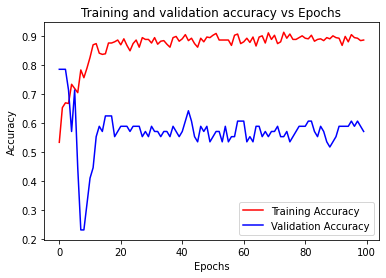

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


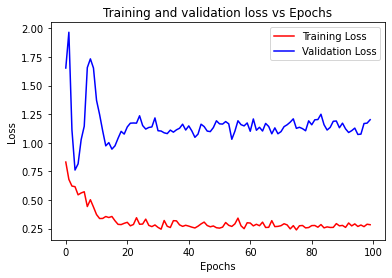

In [20]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Training and validation accuracy vs Epochs')
plt.legend()
accuracy_fig_name = "accuracy.eps"
plt.savefig(os.path.join(char, accuracy_fig_name))
plt.show()


plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and validation loss vs Epochs')
plt.legend()
loss_fig_name = "loss.eps"

plt.savefig(os.path.join(char, loss_fig_name))
plt.show()

In [21]:
training_accuracy = train_score[1]*100
validation_accuracy = val_score[1]*100
test_accuracy = test_score[1]*100

print("The training accuracy is: " + str(training_accuracy) + ' %')
print("The validation accuracy is: " + str(validation_accuracy) + ' %')
print("The test accuracy is: " + str(test_accuracy) + ' %')

The training accuracy is: 91.5463924407959 %
The validation accuracy is: 57.14285969734192 %
The test accuracy is: 61.666667461395264 %


In [22]:
test_accuracy = test_score[1]*100
test_precision = test_score[2]*100
test_recall = test_score[3]*100
tp = int(test_score[4])
tn = int(test_score[5])
fp = int(test_score[6])
fn = int(test_score[7])

f1 = 2*((test_precision*test_recall)/(test_precision+test_recall))
sensitivity = (tp/(tp+fn))*100
specificity = (tn/(tn+fp))*100

In [23]:
print("Test Accuracy: {}".format(test_accuracy))
print("Test Precision: {}".format(test_precision))
print("Test Recall: {}".format(test_recall))
print("True Positive: {}".format(tp))
print("Test Negetive: {}".format(tn))
print("False Positive: {}".format(fp))
print("False Negetive: {}".format(fn))
print("Sensitivity: {}".format(sensitivity))
print("Specificity: {}".format(specificity))

Test Accuracy: 61.666667461395264
Test Precision: 85.71428656578064
Test Recall: 55.81395626068115
True Positive: 24
Test Negetive: 13
False Positive: 4
False Negetive: 19
Sensitivity: 55.81395348837209
Specificity: 76.47058823529412


In [31]:
from contextlib import redirect_stdout

readme_name_text = "readme.txt"
print("Please read the text file named " + readme_name_text + " for detailed information of the model.")

completeName_txt = os.path.join(char, readme_name_text) 

readme = open(completeName_txt, "w")

if len(os.listdir(TRAINING_DIR)) > 2:
    readme.write("This is a MULTICLASS CLASSIFICATION")
else:
    readme.write("This is a BINARY CLASSIFICATION")


readme.write("\n\n--HYPERPARAMETERS--\n")
readme.write(str(augmentation))
readme.write("\nInitial Learning Rate = " + str(learning_rate))
readme.write("\nNo. of epochs = " + str(len(acc)))
readme.write("\nBatch Size = " + str(batch_size))


readme.write("\n\n--MODEL-PARAMETERS--")
readme.write("\nActivation Function = relu")
readme.write("\nDropout = " + str(int(dropout*100)) + "%")
readme.write("\nActivation function of the output layer = " + str(output_activation))
readme.write("\nCost function of the model = " + str(losses))
readme.write("\nOptimizer = " + str(optimizer) + "\n\n")


readme.write("Trained on a Resnet50 Model\n")
with redirect_stdout(readme):
    model.summary()
        
    
readme.write("\n\n--MODEL-PERFORMANCE--")
readme.write("\nTest Accuracy = " + str(test_accuracy) + " %")
readme.write("\nTest Precision = " + str(test_precision) + " %")
readme.write("\nTest Recall = " + str(test_recall) + " %")
readme.write("\nTrue Positive = " + str(tp))
readme.write("\nTrue Negetive = " + str(tn))
readme.write("\nFalse Positive = " + str(fp))
readme.write("\nFalse Negetive = " + str(fn))
readme.write("\nSensitivity = " + str(sensitivity))
readme.write("\nSpecificity = " + str(specificity) + " \n\n\n")


readme.write("\n\n--MODEL-CHARACTERISTICS--")
readme.write("\nacc = " + str(acc))
readme.write("\n\nval_acc = " + str(val_acc))
readme.write("\n\nloss = " + str(loss))
readme.write("\n\nval_loss = " + str(val_loss))


readme.write("\nExecution Time: {} seconds".format(duration))

readme.write("\n\nCreated using Self-Regulated Image Classifier using Convolution Neural Network")

readme.close()

Please read the text file named readme.txt for detailed information of the model.
